# 인자분석 : 회전
요인분석에서 회전은 공통 요인들이 변수들 간의 상관관계를 더 명확하게 해석할 수 있도록 도와주는 중요한 단계이다.  
회전을 통해 얻을 수 있는 주요 이점은 다음과 같다:

1. 해석의 용이성:
    * 회전을 하지 않은 요인 적재량은 해석하기 어려울 수 있다. 
    * 회전은 요인 적재량의 패턴을 단순화하여 특정 요인에 강하게 적재된 변수들이 명확히 드러나도록 한다. 
    * 이를 통해 요인 구조를 쉽게 이해하고 해석할 수 있다.
2. 요인의 명확성:
    * 회전은 요인들이 서로 독립적이거나 상관관계를 가지도록 조정하여, 각 요인이 독립적인 의미를 갖도록 한다. 
    * 이는 요인들이 서로 혼합되지 않고, 각 요인이 고유한 특성을 가지도록 하여 명확한 해석을 가능하게 한다.
3. 분산의 재분배:
    * 회전은 요인들 간의 분산을 재분배하여, 각 요인이 전체 변동성에서 차지하는 비율을 더 균등하게 만든다. 
    * 이는 요인들이 데이터의 변동성을 보다 고르게 설명할 수 있도록 도와준다.


## 회전의 수학적 배경

회전의 기본 아이디어는 요인 적재량 행렬 $\Lambda$ 를 새로운 행렬 $\Lambda^*$ 로 변환하는 것이다.  
이 변환은 다음과 같은 형태를 가진다:
$$
\Lambda^* = \Lambda T
$$
여기서  T 는 직교 또는 사각 회전 행렬이다.


## 자료 생성

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import wishart, multivariate_normal
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, Rotator
import matplotlib.pyplot as plt

In [5]:
# 시드값 설정
np.random.seed(2022)

# 자료 만들기
# 자료 만들기
pp = 8
Sigma = wishart.rvs(df=pp, scale=np.identity(pp), size=1)
R = np.diag(1 / np.sqrt(np.diag(Sigma))) @ Sigma @ np.diag(1 / np.sqrt(np.diag(Sigma)))

print("Sigma:")
print(pd.DataFrame(np.round(Sigma, 2)))

Sigma:
      0     1     2     3     4      5     6      7
0  8.62 -0.00 -0.81  5.83  0.88  -0.26  2.99   2.93
1 -0.00  7.04 -0.37  0.75  1.43  -6.12  2.74  -0.34
2 -0.81 -0.37  2.91  0.69  0.47   2.26 -1.81  -2.73
3  5.83  0.75  0.69  5.97  1.48  -1.76  1.70  -1.46
4  0.88  1.43  0.47  1.48  6.37  -3.49 -0.35   0.94
5 -0.26 -6.12  2.26 -1.76 -3.49  18.66 -4.02  -0.92
6  2.99  2.74 -1.81  1.70 -0.35  -4.02  3.10   2.24
7  2.93 -0.34 -2.73 -1.46  0.94  -0.92  2.24  11.03


In [6]:
print("Determinant of Sigma:", np.linalg.det(Sigma))

Determinant of Sigma: 1567.3240937072296


In [7]:
print("행렬 R :\n")
print(pd.DataFrame(np.round(R, 2)))

행렬 R :

      0     1     2     3     4     5     6     7
0  1.00 -0.00 -0.16  0.81  0.12 -0.02  0.58  0.30
1 -0.00  1.00 -0.08  0.12  0.21 -0.53  0.59 -0.04
2 -0.16 -0.08  1.00  0.17  0.11  0.31 -0.60 -0.48
3  0.81  0.12  0.17  1.00  0.24 -0.17  0.40 -0.18
4  0.12  0.21  0.11  0.24  1.00 -0.32 -0.08  0.11
5 -0.02 -0.53  0.31 -0.17 -0.32  1.00 -0.53 -0.06
6  0.58  0.59 -0.60  0.40 -0.08 -0.53  1.00  0.38
7  0.30 -0.04 -0.48 -0.18  0.11 -0.06  0.38  1.00


In [8]:
n = 10000
mu = np.zeros(pp)
d1 = multivariate_normal.rvs(mean=mu, cov=Sigma, size=n)
d1 = pd.DataFrame(d1, columns=[f'X{i}' for i in range(1, pp + 1)])

# 여러가지 회전기법

1. 직교 회전 (Orthogonal Rotation):  

* Varimax: 변수들이 특정 요인에 높은 적재량을 갖도록 최대화하여 해석을 용이하게 한다.  

* Quartimax: 각 요인에 대한 변수들의 적재량의 분산을 최소화하여 요인을 단순화한다.  

2. 사각 회전 (Oblique Rotation):  

* Promax: Varimax 회전 후 사각 변환을 통해 요인들이 상관관계를 가질 수 있도록 한다.  

* Oblimin: 요인들이 서로 상관관계를 가지면서도 해석이 용이하도록 조정한다.

여러가지 회전 기법들을 살펴보자.  
우선, 사전에 미리 결과를 시각화할 수 있는 함수 하나를 준비한다.

In [9]:
# 결과 시각화 함수
def visual_2(loadings, threshold=0.6):
    loadings_df = pd.DataFrame(loadings, columns=[f'Fact{i}' for i in range(1, loadings.shape[1] + 1)])
    loadings_df = loadings_df.astype(str).map(lambda x: '' if abs(float(x)) < threshold else round(float(x), 3))
    loadings_df.insert(0, 'Var', [f'X{i}' for i in range(1, loadings.shape[0] + 1)])
    return loadings_df

## 회전없음

In [10]:
mm = 3
fa_none = FactorAnalyzer(n_factors=mm, rotation=None)
fa_none.fit(StandardScaler().fit_transform(d1))

print("\nVisual for no rotation:")
print(visual_2(fa_none.loadings_))


Visual for no rotation:
  Var  Fact1  Fact2 Fact3
0  X1  0.748             
1  X2                    
2  X3                    
3  X4         0.788      
4  X5                    
5  X6                    
6  X7   0.96             
7  X8                    


## Varimax

In [11]:
fa_varimax = FactorAnalyzer(n_factors=mm, rotation='varimax')
fa_varimax.fit(StandardScaler().fit_transform(d1))

print("\nVisual for varimax rotation:")
print(visual_2(fa_varimax.loadings_))


Visual for varimax rotation:
  Var  Fact1  Fact2  Fact3
0  X1  0.946              
1  X2                0.774
2  X3        -0.793       
3  X4  0.948              
4  X5                     
5  X6               -0.718
6  X7         0.703       
7  X8         0.632       


## Promax

In [12]:
fa_promax = FactorAnalyzer(n_factors=mm, rotation='promax')
fa_promax.fit(StandardScaler().fit_transform(d1))

print("\nVisual for promax rotation:")
print(visual_2(fa_promax.loadings_))


Visual for promax rotation:
  Var  Fact1  Fact2  Fact3
0  X1  1.002              
1  X2                 0.81
2  X3        -0.792       
3  X4  0.962              
4  X5                     
5  X6               -0.745
6  X7         0.669       
7  X8         0.635       


## quartimax

In [13]:
# 추가적인 회전 방법
rotator = Rotator()

# rotation = 'quartimax'
fa_quartimax = FactorAnalyzer(n_factors=mm, rotation=None)
fa_quartimax.fit(StandardScaler().fit_transform(d1))
fa_quartimax.loadings_ = rotator.fit_transform(fa_quartimax.loadings_, 'quartimax')

## oblimin

In [14]:
# rotation = 'oblimin'
fa_oblimin = FactorAnalyzer(n_factors=mm, rotation=None)
fa_oblimin.fit(StandardScaler().fit_transform(d1))
fa_oblimin.loadings_ = rotator.fit_transform(fa_oblimin.loadings_, 'oblimin')

print("\nVisual for oblimin rotation:")
print(visual_2(fa_oblimin.loadings_))


Visual for oblimin rotation:
  Var  Fact1  Fact2  Fact3
0  X1         0.946       
1  X2                0.774
2  X3 -0.793              
3  X4         0.948       
4  X5                     
5  X6               -0.718
6  X7  0.703              
7  X8  0.632              


# 회전의 효과분석

In [15]:
# 회전의 효과 분석 - 열 단위
def column_variance(loadings):
    return np.var(loadings**2, axis=0)

print("\nColumn variance without rotation:", np.round(column_variance(fa_none.loadings_), 2))
print("Column variance with varimax rotation:", np.round(column_variance(fa_varimax.loadings_), 2))
print("Column variance with promax rotation:", np.round(column_variance(fa_promax.loadings_), 2))
print("Column variance with quartimax rotation:", np.round(column_variance(fa_quartimax.loadings_), 2))
print("Column variance with oblimin rotation:", np.round(column_variance(fa_oblimin.loadings_), 2))


Column variance without rotation: [0.07 0.04 0.01]
Column variance with varimax rotation: [0.14 0.05 0.05]
Column variance with promax rotation: [0.17 0.05 0.06]
Column variance with quartimax rotation: [0.05 0.14 0.05]
Column variance with oblimin rotation: [0.05 0.14 0.05]


* Column variance without rotation: 
    - 회전을 하지 않은 경우, 요인 1의 분산이 가장 크며, 요인 2와 요인 3의 분산은 상대적으로 작다. 
    - 이는 요인 1이 데이터의 변동성을 주로 설명하고 있음을 나타낸다.
    - [0.07, 0.04, 0.01]

* Column variance with varimax rotation: 
    - Varimax 회전은 요인 1의 분산을 크게 증가시키고, 요인 2와 요인 3의 분산을 균등하게 만든다. 
    - 이는 요인들이 데이터의 변동성을 보다 고르게 설명할 수 있도록 한다.
    - [0.14, 0.05, 0.05]

* Column variance with promax rotation: 
    - Promax 회전은 요인 1의 분산을 더욱 증가시키고, 요인 2와 요인 3의 분산을 약간 증가시킨다. 
    - 이는 요인들이 데이터의 변동성을 더욱 명확하게 설명하도록 한다.
    - [0.17, 0.05, 0.06]

* Column variance with quartimax rotation: 
    - Quartimax 회전은 요인 2의 분산을 크게 증가시키고, 요인 1과 요인 3의 분산을 상대적으로 감소시킨다. 
    - 이는 특정 요인이 데이터의 변동성을 주로 설명하도록 한다.
    - [0.05, 0.14, 0.05]

* Column variance with oblimin rotation: 
    - Oblimin 회전은 Quartimax 회전과 유사한 결과를 보인다.
    - 요인 2의 분산이 크게 증가하고, 요인 1과 요인 3의 분산이 상대적으로 감소한다.
    - [0.05, 0.14, 0.05]

In [16]:
# 회전의 효과 분석 - 행 단위
def row_variance(loadings):
    return np.var(loadings**2, axis=1)

print("\nRow variance without rotation:", np.round(row_variance(fa_none.loadings_), 2))
print("Row variance with varimax rotation:", np.round(row_variance(fa_varimax.loadings_), 2))
print("Row variance with promax rotation:", np.round(row_variance(fa_promax.loadings_), 2))
print("Row variance with quartimax rotation:", np.round(row_variance(fa_quartimax.loadings_), 2))
print("Row variance with oblimin rotation:", np.round(row_variance(fa_oblimin.loadings_), 2))


Row variance without rotation: [0.03 0.01 0.01 0.06 0.   0.   0.17 0.  ]
Row variance with varimax rotation: [0.16 0.08 0.09 0.16 0.   0.06 0.02 0.03]
Row variance with promax rotation: [0.19 0.09 0.08 0.18 0.   0.06 0.02 0.04]
Row variance with quartimax rotation: [0.16 0.08 0.09 0.16 0.   0.06 0.02 0.03]
Row variance with oblimin rotation: [0.16 0.08 0.09 0.16 0.   0.06 0.02 0.03]


* Row variance without rotation: 
    - 회전을 하지 않은 경우, 변수 7의 분산이 가장 크며, 나머지 변수들의 분산은 상대적으로 작다. 
    - 이는 특정 변수가 데이터의 변동성을 주로 설명하고 있음을 나타낸다.
	- [0.03, 0.01, 0.01, 0.06, 0.00, 0.00, 0.17, 0.00]

* Row variance with varimax rotation: 
    - Varimax 회전은 변수들의 분산을 보다 균등하게 만든다.
    - 이는 각 변수가 데이터의 변동성을 보다 고르게 설명할 수 있도록 한다.
	- [0.16, 0.08, 0.09, 0.16, 0.00, 0.06, 0.02, 0.03]

* Row variance with promax rotation: 
    - Promax 회전은 변수들의 분산을 약간 더 증가시켜, 각 변수가 데이터의 변동성을 보다 명확하게 설명할 수 있도록 한다.
	- [0.19, 0.09, 0.08, 0.18, 0.00, 0.06, 0.02, 0.04]
    
* Row variance with quartimax rotation: 
    - Quartimax 회전은 Varimax 회전과 유사한 결과를 보인다. 
    - 변수들의 분산이 보다 균등하게 분포되어 있다.
    - [0.16, 0.08, 0.09, 0.16, 0.00, 0.06, 0.02, 0.03]

* Row variance with oblimin rotation:
    - Oblimin 회전도 유사한 결과를 보인다. 
    - 변수들의 분산이 보다 균등하게 분포되어 있다.
	- [0.16, 0.08, 0.09, 0.16, 0.00, 0.06, 0.02, 0.03]

## 종합 해석

- 회전의 효과 분석 결과를 통해, 회전 방법이 요인분석의 결과에 미치는 영향을 확인할 수 있다.  
- 각 회전 방법은 요인 적재량의 분산을 재분배하여, 요인들이 데이터의 변동성을 보다 고르게 설명할 수 있도록 한다.  
- 특히 Varimax와 Promax 회전은 요인들이 데이터의 변동성을 명확하게 설명할 수 있도록 하여, 해석의 용이성을 높인다.  
- Quartimax와 Oblimin 회전은 특정 요인이 데이터의 변동성을 주로 설명하도록 하여, 요인 구조를 단순화하는 데 도움이 된다.

# biplot 그리기

In [17]:
# biplot 그리기 함수
def biplot(loadings, title):
    D1 = loadings[:, :2]
    fig, ax = plt.subplots()
    ax.scatter(D1[:, 0], D1[:, 1], color='blue', s=100)

    for i in range(D1.shape[0]):
        ax.text(D1[i, 0], D1[i, 1], d1.columns[i], fontsize=12, ha='right')

    ax.set_xlabel('Factor 1', fontsize=14)
    ax.set_ylabel('Factor 2', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    for i in range(D1.shape[0]):
        ax.arrow(0, 0, D1[i, 0], D1[i, 1], color='red', alpha=0.5, head_width=0.05)

    plt.show()

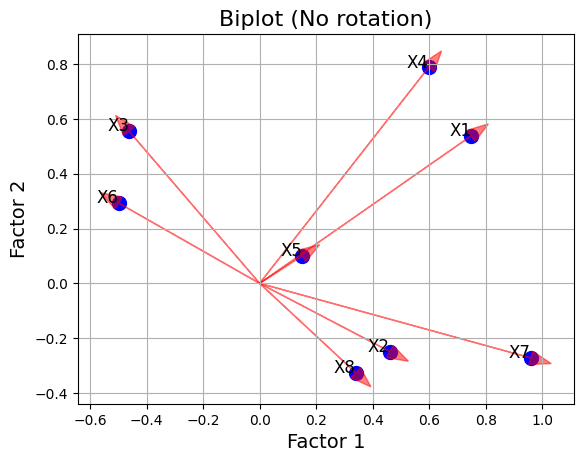

In [18]:
# biplot 그리기
biplot(fa_none.loadings_, 'Biplot (No rotation)')

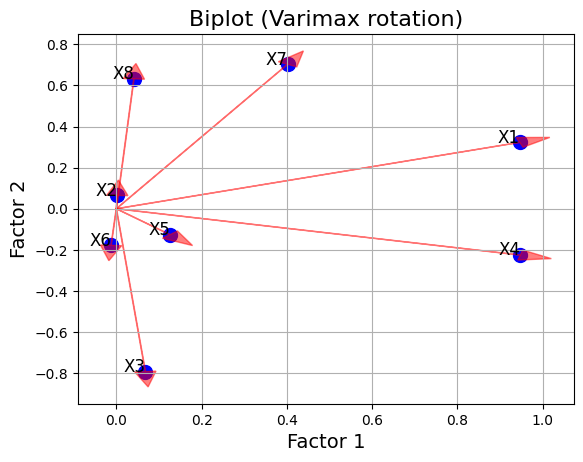

In [21]:
biplot(fa_varimax.loadings_, 'Biplot (Varimax rotation)')

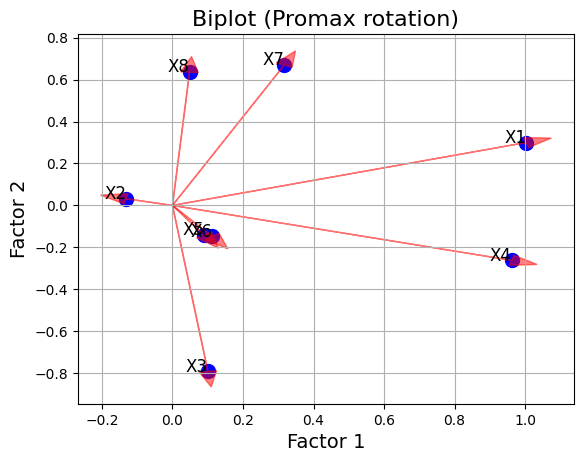

In [22]:
biplot(fa_promax.loadings_, 'Biplot (Promax rotation)')

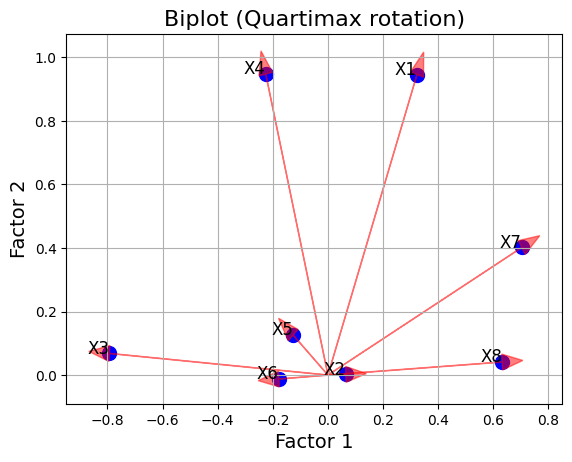

In [23]:
biplot(fa_quartimax.loadings_, 'Biplot (Quartimax rotation)')

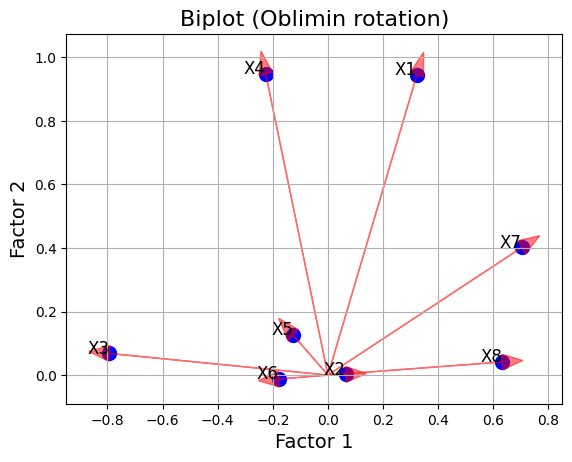

In [24]:
biplot(fa_oblimin.loadings_, 'Biplot (Oblimin rotation)')

In [19]:
# varimax 적용
ro = Rotator().fit_transform(fa_none.loadings_, 'varimax')
print("\nVarimax Rotation Matrix:")
print(pd.DataFrame(np.round(ro @ ro.T, 3)))


Varimax Rotation Matrix:
       0      1      2      3      4      5      6      7
0  1.001 -0.013 -0.186  0.813  0.067 -0.036  0.580  0.246
1 -0.013  0.603 -0.147  0.166  0.190 -0.567  0.497 -0.008
2 -0.186 -0.147  0.648  0.215  0.077  0.229 -0.602 -0.490
3  0.813  0.166  0.215  1.002  0.207 -0.137  0.356 -0.118
4  0.067  0.190  0.077  0.207  0.097 -0.163  0.111 -0.091
5 -0.036 -0.567  0.229 -0.137 -0.163  0.547 -0.549 -0.068
6  0.580  0.497 -0.602  0.356  0.111 -0.549  0.996  0.424
7  0.246 -0.008 -0.490 -0.118 -0.091 -0.068  0.424  0.405


In [20]:
# 전체 자료의 variance 대비 i번째 공통인자의 설명력 보기
def ratio(fa):
    loadings = fa.loadings_**2
    total_variance = np.sum(loadings) + np.sum(fa.get_uniquenesses())
    return np.sum(loadings, axis=0) / total_variance

print("\nExplanation Ratio for varimax rotation:")
print(ratio(fa_varimax))

print("\nExplanation Ratio for promax rotation:")
print(ratio(fa_promax))


Explanation Ratio for varimax rotation:
[0.24706285 0.21615819 0.19927042]

Explanation Ratio for promax rotation:
[0.26000332 0.20993728 0.20192448]
